In [166]:
import pden
import pden.Net
import pden.Operations
import pden.PDENet

import tensorflow as tf

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import clear_output

%load_ext autoreload
%autoreload 1

%aimport pden.Net
%aimport pden.Operations
%aimport pden.PDENet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
def der(y, x, y_shape: int, x_shape: int):
    ys = tf.split(y, [1] * y_shape, 1)
    def _der(i, j=[]):
        f = ys[i]
        for _j in j:
            fs = tf.gradients(f, x)[0]
            f  = tf.split(fs, [1] * x_shape, 1)[_j]        
        return f
    return _der

In [193]:
net = pden.Net.BasicNet(
    pden.Operations.Linear(feature_out=2, random_init = True),
    pden.Operations.ActivationFunction(tf.nn.tanh),
    pden.Operations.Linear(feature_out=2, feature_in=2, random_init = True),
    pden.Operations.ActivationFunction(tf.nn.tanh),
    pden.Operations.Linear(feature_in=2, feature_out=1, random_init = True)
)

pnet = pden.PDENet.PDENET(net=net)
print(net)

Net 10:
	11	Linear: [1 -> 2]
	14	Activation funciton: <function tanh at 0x12c1bdc20>
	6	Linear: [2 -> 2]
	17	Activation funciton: <function tanh at 0x12c1bdc20>
	24	Linear: [2 -> 1]


In [194]:
x = tf.placeholder(tf.float64, [None, 1])
y = pnet.forward(x)

init_x = tf.placeholder(tf.float64, [1, 1])
init_y = pnet.forward(init_x)

bc_x = tf.placeholder(tf.float64, [1, 1])
bc_y = pnet.forward(bc_x)

der_gen = pnet.derivatives()
dy = der_gen(0, j=[0])

In [195]:
pnet = pnet.add_loss(tf.reduce_mean(tf.pow(dy * tf.pow(y, 2) - 0.5 * tf.sin(2 * x) * tf.sin(x), 2)))
pnet = pnet.add_loss(tf.reduce_mean(tf.pow(bc_y - tf.sin(np.array([1.0])), 2)), weight=1.0)
pnet = pnet.add_loss(tf.reduce_mean(tf.pow(init_y - 0.0, 2)), weight=1.0)

In [201]:
learning_rate = 1e-3
training_epochs = 5001
display_step = 250

opt = tf.train.AdamOptimizer(learning_rate = learning_rate)
train = opt.minimize(pnet.loss)

init = tf.global_variables_initializer()

In [202]:
X = np.linspace(0, 1, 100).reshape(-1, 1)

Training error for net is "0.0026148528108452663". Epoch 5000


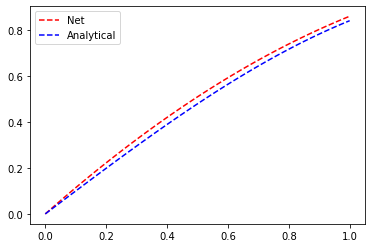

Optimization Finished!


In [205]:
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    
#     P = np.random.uniform(0, 0.5, size=(1,))
    
    _, l, Y = sess.run([train, pnet.loss, y], feed_dict={
        x: X,
        init_x: np.array([[0.0]]),
        bc_x: np.array([[1.0]])
    })
    
    if epoch % display_step == 0:
        clear_output(wait=True)
        
        print(f'Training error for net is "{l}". Epoch {epoch}')
        
        plt.plot(X.flatten(), Y.flatten(), '--r', label='Net')
        plt.plot(X.flatten(), np.sin(X.flatten()), '--b', label='Analytical')
        plt.legend()
        plt.show()

        
print("Optimization Finished!")